# General Limit Cycles

This notebook explains how to construct a very general family of dynamical systems that exhibit limit cycles. 

## Introduction

First we give a simple example of a stable attracting limit cycle given by a circle. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad, jit, vmap

from vector_field import vector_field, utilities

# Defining a general class of functions which define the
# tangential component of the CPG update. 

class SimpleRotationalField(vector_field.VectorField):
    def __init__(self):
        pass 
    def get_gradient(self,x):
        theta = np.arctan2(x[0], x[1])
        return np.array([-np.cos(theta), np.sin(theta)])

square = lambda x: jnp.dot(x, x)
bump = lambda x: jnp.exp(-jnp.dot(x, x))
s1 = vector_field.FunctionalPotentialField(square)
s2 = vector_field.FunctionalPotentialField(bump)
s3 = vector_field.LinearCombinationPotentialField([s1, s2], [0.1, 0.9])

m = SimpleRotationalField()
d = vector_field.LinearCombinationVectorField([s3, m])

To illustrate the phase plot, we simulate the history. 

In [3]:
history = utilities.simulate_trajectory(
    d, jnp.array([0.5, 0.5]),
    step_size = 0.1, num_iters = 100)

Lastly, we visualize the trajectory:

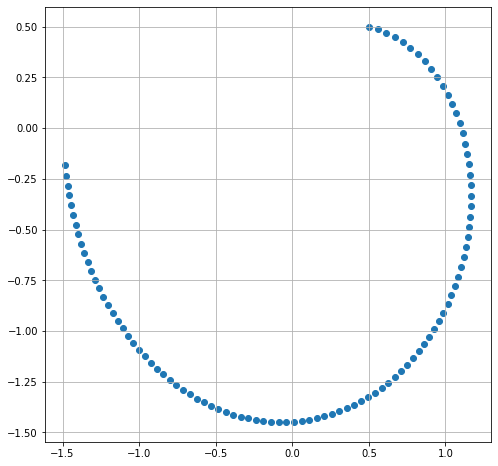

In [4]:
def plot_history(x_history, **subplot_kwargs):
    fig, ax = plt.subplots(**subplot_kwargs)
    ax.scatter(x_history[:,0], x_history[:,1])
    ax.grid(True)

plot_history(history, figsize=(8,8))

## Why does it work?

The above construction works by building a vector field out of a linear combination of: 

1. A radial component, causing flow vectors to point towards a particular closed loop (here, a circle).
2. A tangential component, causing flow vectors to point in a clockwise direction (```SimpleRotationalField```)

The radial component is in turn parametrized as the gradient of a function $f: R^2 \to R$. Let's take a look at just the radial component first.  


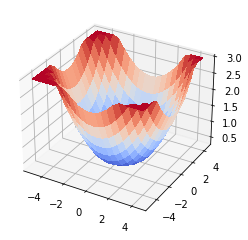

In [7]:
utilities.plot_potential_field(s3, np.array([-5, 5]), np.array([-5, 5]), step_size = 0.5, max_clip = 3)

Let's take a look at the cross-section to visualize it better. 
Since the potential field is constructed to be radially symmetric, any ray from 0 will give the same cross section. 

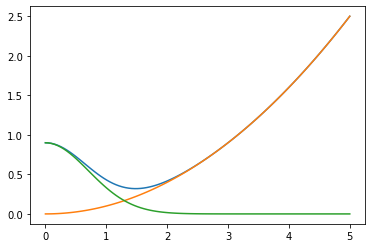

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def f3(x):
    return s3.get_value(np.array([x,0]))

def f1(x):
    return 0.1 * s1.get_value(np.array([x,0])) 

def f2(x):
    return 0.9 * s2.get_value(np.array([x,0]))

xs = np.linspace(0, 5, 100)
ys = np.zeros_like(xs)
y1s = np.zeros_like(xs)
y2s = np.zeros_like(xs)
for i, x in enumerate(xs):
    ys[i] = f3(x)
    y1s[i] = f1(x)
    y2s[i] = f2(x)

fig, ax = plt.subplots()
ax.plot(xs, ys)
ax.plot(xs, y1s)
ax.plot(xs, y2s)

Analyzing this image tells us a lot about how the construction works. 

The potential field $h = 0.1f + 0.9g$ is constructed out of a convex function $f$ and a bump function $g$. $f$ has a global minimum at $0$ and b has a global maximum at $0$. At distances far from the origin, the convex function dominates and so the potential increases with $r$. At distances close to the origin, the bump function dominates so the potential decreases with $r$. 

The linear combination of these two potentials results in an inflection point somewhere 'in the middle'. 
By radial symmetry, the minimal set of $h$ is given by a circle. When considering the dynamics induced by the gradient of the potential, it becomes clear that the minimal set is both invariant and attracting. 

Finally, the added rotational vector field makes the minimal set into a limit cycle. 

## Generalizing the Formula

### Constructing an Arbitrary Closed Loop 

Having understood the 'recipe' above, we can proceed to generalize it into something more flexible. 

Define $f_\theta: R^{+}_0 \to R$ to be $f$ restricted to the line given by $\theta = c$ and define $g_\theta, h_\theta$ similarly. Instead of convex $f$ and bump $g$, we can relax this to the following condition: 

For all $\theta$, the functions $f_\theta(r), g_\theta(r)$ must be **quasiconvex** on their domain. This guarantees that $h_\theta = af_\theta + bg_\theta$ is also quasiconvex so long as $a, b \geq 0$.

If you're not familiar, quasiconvexity is a type of relaxation of general convexity: https://en.wikipedia.org/wiki/Quasiconvex_function

Crucially, a strictly quasiconvex function is guaranteed to have a unique minimum on any convex subset. The domain $[0, \infty]$ is such a convex set. Assuming our construction of $h$ is also smooth, the collection of minima $S_h = \{\min h_\theta: \theta \in [0, 2\pi]\}$ forms a closed, connected curve. 

The above argument suggests a natural parametrization of $h$.
1. Change coordinates from $h(x,y)$ to $h(r, \theta)$. 
2. To encode the periodicity boundary condition of $\theta$, we may wish to parametrize $h(r, \cos\theta, \sin\theta)$ instead. This is equivalent to the parametrization $h(\hat x, \hat y,r)$ where $(\hat x, \hat y)$ is the unit vector in direction $(x,y)$. 
3. Choose some parametric function such that $h(\hat x, \hat y, r)$ is convex in $r$. 

The following tools may be useful in constructing a suitable family of $h$: 
- Disciplined quasiconvex programming (DCQP): https://www.cvxpy.org/tutorial/dqcp/index.html
- Partially-input-convex neural networks (PICNN): https://arxiv.org/pdf/1609.07152.pdf

### Constructing a Limit Cycle

The above construction gives us a closed loop $S_h$ and associated dynamics $\dot x = (- \nabla h)(x)$. By considering $h$ to be a Lyapunov function, we immediately have that the closed loop is attracting and invariant under these dynamics. (TODO: I'm reasonably sure this is true, but I need to check this part rigorously) 

However we still need to turn $S_h$ into a limit cycle. At the moment, we have not ruled out the case where some of the points on the loop are local minima. 

Conversely, if we are able to eliminate critical points of $h$ within a region of interest, then by the Poincare-Bendixson Theorem (page 2 of https://math.mit.edu/~jorloff/suppnotes/suppnotes03/lc.pdf) $h$ will exhibit a closed trajectory within that region; from the previous arguments this will be unique, stable and attracting. 

#### Eliminating Critical Points

To eliminate critical points, we choose to superimpose an additional vector field $v(r, \theta)$. We can endow $v$ with a chosen directionality by restricting the parametrization $v = u(r, \hat x, \hat y)(-\hat y, \hat x)$; i.e. $v$ always points in the clockwise rotational direction and the magnitude is varied freely. Informally, the impetus provided by $v$ needs to be large enough to help $x$ 'escape' local minima (local bowls).

To make this happen, we need to assume bounds on the gradient of $h$; i.e. Lipschitz-continuity. Fortunately, if $h$ is smooth this already comes 'for free'. 

Now, how to design $v$? As mentioned, the impetus provided by $v$ needs to be strong enough to help $x$ 'escape' local minima of $- \nabla h$. We have a few options: 
1. Simply don't enforce the restriction and trust the learning / optimization procedure to choose a good choice of $v$. 
2. Strongly enforce the restriction by making $v$ always be larger in norm than the upper bound of $\nabla h$. 
3. Do something more sophisticated in between the two extremes of 'don't enforce at all' and 'strongly enforce'; e.g. $v$ could somehow depend on the magnitude of $\nabla h$ so that $||v||$ is large only when $||\nabla h||$ is small, for example.  

Both (1) and (2) should be explored as valid baselines before we work on (3). 

#### Learning Limit Cycles

We consider two learning settings: 

1. We have paired observations $(x, \dot x)$ and wish to learn the mapping $f(x) = \dot x$. 

Some tools that could be useful: 
- PySindy: https://pysindy.readthedocs.io/en/latest/examples/3_original_paper.html. Provides both an optimization framework, ready-made datasets, and a good starting benchmark. 
